# Classicação do CIFAR-10 usando Convolucional Neural Networks

Esse notebook discute mais a respeito das *Convolutional Neural Network* (CNN) explicando um pouco sobre seu embasamento teórico e sua implementação utilizando ```keras``` em ```tensorflow 2.0```.

Portanto, este documento tem o intuito de apresentar uma introdução no idioma português, que carece de materiais desse tipo.

**Objetivo**

Desenvolver uma CNN acoplada a uma DNN (Dense Neural Network) para prever corretamente as classes do banco de dados CIFAR-10.

**Arquitetura**
![arc](https://user-images.githubusercontent.com/32513366/71742171-a1c3c300-2e3f-11ea-9066-56ce1b243888.png)

A mesma ideia será aplicada para este classificador: uma **CNN** será responsável por encontrar (automaticamente) os atributos (*features*) e uma **DNN** irá utiliza-los para classificar aquela imagem em uma das categorias.

## Módulos utilizados

In [1]:
# Biblioteca básica do python
import numpy as np
# Para o desenvolvimento dos modelos de Deep Learning
import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras import datasets, models, layers, optimizers
# Para fazer alguns gráficos caso necessário
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
# Para aplicar a otimização de parametros da rede
import talos

Using TensorFlow backend.


## CIFAR-10
Ao total, esse banco de dados contém 60,000 imagens com 10 classes diferentes e bem balanceadas (em média 6,000 imagens por classe). As classes são:
- airplane (avião)
- automobile (carro)
- bird (passaro)
- cat (gato)
- deer (veado)
- dog (cachorro)
- frog (sapo)
- horse (cavalo)
- ship (navio)
- truck (caminhão)

Cada imagem ,ou tensor, possui a seguinte dimensão: **32 X 32 X 3** que respectivamente se trata da: altura, largura e canais RGB. 
Cada *label* apresenta um valor de 0 a 9, representando respectivamente a classe daquela imagem.

In [2]:
# Importando banco de dados
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data();

In [3]:
# Normalizando os valores dos pixels para o intervalo de 0 a 1
train_images, test_images = train_images/255.0, test_images/255.0

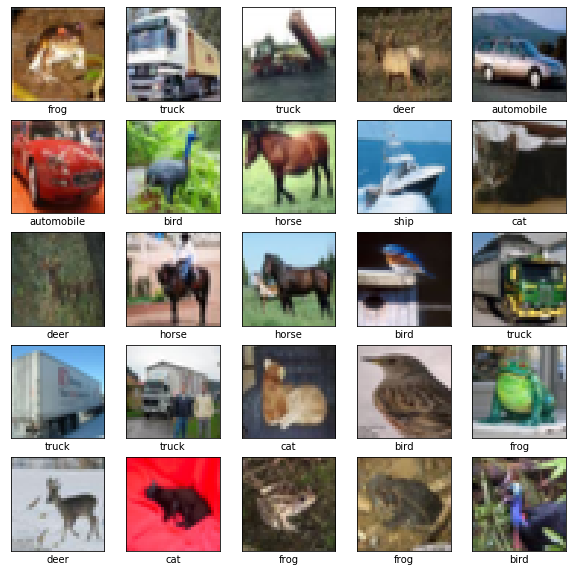

In [4]:
# Definindo as classes
class_names = ['airplane','automobile','bird','cat', 'deer','dog','frog','horse','ship','truck']

# Analisando algumas imagens do CIFAR
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i][0]])

In [5]:
# Para este notebook irei juntar ambos os conjuntos train/test (por causa do otimizador talos)
x = np.concatenate((train_images, test_images))
y = np.concatenate((train_labels, test_labels))

# Parte 1: Criando a Rede de Convolução (CNN)

As redes convolucionais podem ser divididas em dois tipos de camadas principais que juntas são responsáveis por extrair atributos capazes de auxiliar na classicação. São elas a convolução e *max pooling*.

A convolução, representada no ```keras``` pela função ```Conv2D```, é responsável pela aplicação de um filtro sobre a imagem e esta é a primeira etapa na coleta de atributos. Trata-se de uma operação linear de multiplicação de matrizes elemento a elemento (*element-wise*) entre o filtro e a imagem (uma parte da imagem de cada vez).

![conv)](https://user-images.githubusercontent.com/32513366/71742393-670e5a80-2e40-11ea-9f6d-262e3eedc122.gif)

Baseado no exemplo acima, você pode ver o filtro (chamado comumente de *filter* ou *kernel*) em amarelo e a imagem em verde. O processo segue as etapas:
- Filtro passa sobre uma parcela da imagem
- Ocorre a operação *element-wise*: **kernel ∘ parcela da imagem**
- A matriz resultante dessa operação é somada para um valor escalar
- Filtro se move e repete o processo até acabar a imagem

Ao final desse processo de convolução é gerado um *convoluted feature* que irá conter informações da imagem de forma mais condensada.

O *Max Pooling*, representado no ```keras``` pela função ```MaxPool2D```, é uma fase mais simples e atua em cima de cada *convoluted feature* (lembre-se que cada filtro gera o seu respectivo) após o processo de convolução. Seu objetivo maior é diminuir a dimensionalidade daquela saída, diminuindo assim o custo computacional através da redução de parâmetros para serem treinados. Abaixo temos um exemplo de como é feito em si o *Max Pooling*:

![MP](https://user-images.githubusercontent.com/32513366/71745384-b6f11f80-2e48-11ea-93a8-5791b29861e3.png)

O processo é feito da seguinte maneira: é escolhido apenas o **maior** valor de cada região para compor a nova saída, que agora apresenta uma redução de dimensões (altura e largura).

Todavia, a implementação de todo esse processo não é trivial e requer do operador a definição de alguns parâmetros que **não podem ser aprendidos pela rede** (forma geral apenas aprende os pesos/bias). Eu irei apresenta-los em termos de código, seguindo como padrão a aplicação em ```keras``` desenvolvida abaixo:
- ```filters```: quantidade de filtros que serão utilizados para fazer o processo de convolução em cada entrada.
- ```kernel_size```: tamanho do filtro dado em (altura, largura) para o processo de convolução.
- ```strides```: tamanho do passo que o filtro irá dar para se movimentar horizontalmente e verticalmente sobre a imagem. No exemplo anterior para convolução, seu valor é 1 passo horizontal e 1 passo vertical. Já para o *max pool*, seu valor é de 2 passos horizontais e 2 passos verticais (vale ressaltar que no processo de *max pool* é incomum ocorrer regiões com intersecção).
- ```padding```: trata-se da inserção de bordas na imagem (com valor zero). Essa opção permite que atributos mais próximos das laterais da imagem sejam tão relevalentes quanto os atributos mais centrais. Além disso, a não utilização dessa opção permite uma redução de dimensionalidade natural durante o processo de convolução. Abaixo segue exemplificações visuais para facilitar o entendimento.
    - Com padding (opção *same*)
    ![same_padding_no_strides](https://user-images.githubusercontent.com/32513366/71746263-37b11b00-2e4b-11ea-9ad9-d76cbc3da544.gif)
    - Sem padding (opção *valid*)
    ![no_padding_no_strides](https://user-images.githubusercontent.com/32513366/71746267-38e24800-2e4b-11ea-92e9-72d25a5b7d3e.gif)

- ```pool_size```: tamanho do filtro para ser aplicado o processo de *max pooling*.

Além dessas existem diversos parâmetros que precisam ser definidos antes do treinamento do modelo como a quantidade de camadas, função de ativição, forma de inicialização de pesos e etc. Todavia, os parâmetros listados anteriormente são característicos deste tipo de modelo (CNN).

O modelo CNN proposto inicialmente é composto por 3 camadas de convolução seguidas por sua respectiva camada de *Max Pooling* totalizando 6 camadas.

In [6]:
# Definindo os dimensões de entrada para o modelo
image_shape = (32,32,3)

# Declarando objeto
cnn = models.Sequential()
# Definindo a primeira camada, note que aqui o formato da imagem é aplicado
cnn.add(layers.Conv2D(filters=32, 
                      kernel_size=(3,3),
                      strides=(1,1), 
                      padding='same',
                      activation='relu', 
                      input_shape=image_shape,
                      name='conv2D_input'))
# Definindo a segunda camada
cnn.add(layers.MaxPool2D(pool_size=(2,2),
                         name='maxPool_1'))
# Definindo a terceira camada
cnn.add(layers.Conv2D(filters=64,
                      kernel_size=(3,3),
                      strides=(1,1),
                      padding='same',
                      activation='relu',
                      name='conv2D_1'))
# Definindo a quarta camada
cnn.add(layers.MaxPool2D(pool_size=(2,2),
                         name='maxPool_2'))
# Definindo a quinta camada
cnn.add(layers.Conv2D(filters=128,
                      kernel_size=(3,3),
                      strides=(1,1),
                      padding='same',
                      activation='relu',
                      name='conv2D_2'))
# Definindo a sexta camada
cnn.add(layers.MaxPool2D(pool_size=(2,2),
                         name='maxPool_3'))

In [7]:
# Get a summary from devoloped CNN
cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2D_input (Conv2D)        (None, 32, 32, 32)        896       
_________________________________________________________________
maxPool_1 (MaxPooling2D)     (None, 16, 16, 32)        0         
_________________________________________________________________
conv2D_1 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
maxPool_2 (MaxPooling2D)     (None, 8, 8, 64)          0         
_________________________________________________________________
conv2D_2 (Conv2D)            (None, 8, 8, 128)         73856     
_________________________________________________________________
maxPool_3 (MaxPooling2D)     (None, 4, 4, 128)         0         
Total params: 93,248
Trainable params: 93,248
Non-trainable params: 0
____________________________________________________

# Parte 2: Criando a Rede de Toda-Conectada (DNN)

Trata-se de uma das arquitetura iniciais que surgiram no estudo de *Deep Learning*. Seu modelo consiste em todos os neurônios conectados entre si até o final:
![dnn](https://user-images.githubusercontent.com/32513366/71747029-59ab9d00-2e4d-11ea-91d8-2aa03516f9cd.png)

Sua explicação não faz parte do escopo deste notebook, mas de forma geral seu parâmetro principal (além da profundidade do modelo, isto é, quantidade de camadas) que precisa ser definido é:
- ```units```: quantidades de neurônios presentes naquela camada

Todavia, para conectar a CNN que apresenta uma resposta n-dimensional (4x4x128) em um modelo que precisa de uma entrada vetorial é necessário inserir uma camada extra: ```Flatten```. Essa camada será responsável por tornar a resposta da CNN em uma resposta vetorial de dimensão: (*N*x1) Onde *N* é dado pela multiplicação das dimensões da saída anterior, portanto *N* = 2048.

O modelo de DNN é dado por apenas um camada totalmente conectada a saída.

In [8]:
# Flatten N-D Vetor em 1-D Vetor
cnn.add(layers.Flatten())
# Primeira camada para DNN
cnn.add(layers.Dense(units = 128,
                     activation='relu',
                     name='dense_1'))
# Saída
cnn.add(layers.Dense(units = 10,
                     activation='softmax',
                     name='dense_output'))

In [9]:
# Avalie a arquitetura geral desenvolvida
cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2D_input (Conv2D)        (None, 32, 32, 32)        896       
_________________________________________________________________
maxPool_1 (MaxPooling2D)     (None, 16, 16, 32)        0         
_________________________________________________________________
conv2D_1 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
maxPool_2 (MaxPooling2D)     (None, 8, 8, 64)          0         
_________________________________________________________________
conv2D_2 (Conv2D)            (None, 8, 8, 128)         73856     
_________________________________________________________________
maxPool_3 (MaxPooling2D)     (None, 4, 4, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0

# Parte 3: Compilando o modelo

Nesta etapa, a arquitetura desenvolvida será compilada indicando de forma geral como será feito o aprendizado deste modelo. Será nessa etapa que será definido o ```optmizer``` (método de otimização para ser usado no treinamento), ```loss``` (função a ser otimizada) e ```metrics``` (cálculo para ser utilizado na verificação da qualidade do modelo).

In [10]:
cnn.compile(optimizer='Adam',
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])

# Parte 4: Treinando o modelo
Nesta etapa, o modelo será treinado/validado utilizando apenas o banco de dados *train* para utilizar o *test* na validação final. Aqui é definido principalmente ```epochs```(quantidade de vezes que o modelo irá treinar sobre todo o banco de dados de treino) e ```batch_size``` (tamanho necessário de amostras para atualizar a quantidade de pesos).

O modelo será treinado fazendo um *split* de 30% no banco de dados para validação, esta que será a métrica considerada final.

In [11]:
cnn_training = cnn.fit(x = x,
                       y = y,
                       epochs = 5,
                       batch_size=32,
                       validation_split=0.3,
                       #validation_data=(test_images, test_labels),
                       verbose=2                  
                      )

Train on 42000 samples, validate on 18000 samples
Epoch 1/5
42000/42000 - 47s - loss: 1.4786 - accuracy: 0.4686 - val_loss: 1.1788 - val_accuracy: 0.5768
Epoch 2/5
42000/42000 - 47s - loss: 1.0459 - accuracy: 0.6311 - val_loss: 0.9851 - val_accuracy: 0.6571
Epoch 3/5
42000/42000 - 53s - loss: 0.8632 - accuracy: 0.6996 - val_loss: 0.8367 - val_accuracy: 0.7126
Epoch 4/5
42000/42000 - 51s - loss: 0.7415 - accuracy: 0.7411 - val_loss: 0.8400 - val_accuracy: 0.7096
Epoch 5/5
42000/42000 - 59s - loss: 0.6526 - accuracy: 0.7736 - val_loss: 0.8104 - val_accuracy: 0.7233


Ao final da última *epoch* nossa arquitetura conseguiu uma acurácia de validação de **72%**.
### Avaliando a performance durante o treinamento do modelo

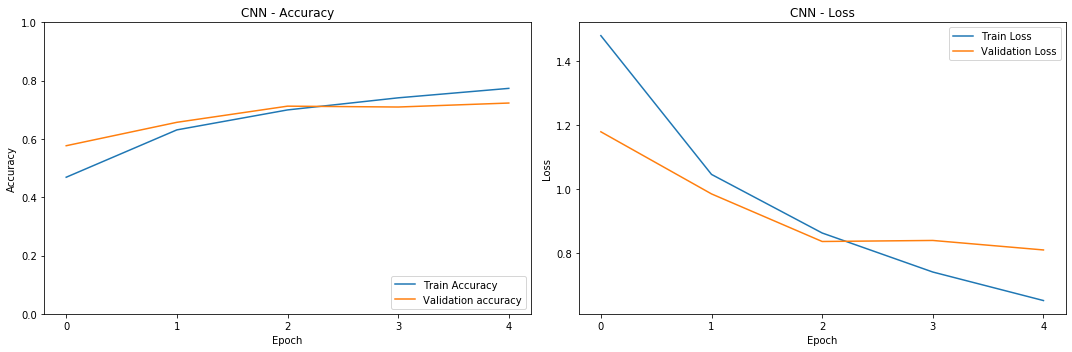

In [12]:
epochs_range = range(0,5)
# Plots
fig, ax = plt.subplots(1,2, figsize=(15,5));
# Accuracy X Epochs
ax[0].plot(cnn_training.history['accuracy'], label='Train Accuracy')
ax[0].plot(cnn_training.history['val_accuracy'], label = 'Validation accuracy')
ax[0].set_title('CNN - Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].set_ylim([0, 1])
ax[0].set_xticks(epochs_range)
ax[0].legend(loc='lower right')
# MSE X Epochs
ax[1].plot(cnn_training.history['loss'], label='Train Loss')
ax[1].plot(cnn_training.history['val_loss'], label = 'Validation Loss')
ax[1].set_title('CNN - Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].set_xticks(epochs_range)
ax[1].legend(loc='upper right')

# Default to improve spaces between the plots
plt.tight_layout()

# Parte 5: Melhorando o modelo

Dado a imensa quantidade de parâmetros que precisamos definir desde a quantidade de camadas até funções de ativação, perguntas como: "Qual a melhor combinação para alcançar a melhor acurácia?" são bem recorrentes.
Todavia, testar todas as possibilidades apresenta alguns problemas:
- a quantidade de combinações cresce exponencialmente
- pode ser tedioso criar manualmente cada combinação

Todavia existe uma biblioteca chamada *talos* que de forma simples e eficaz, utilizando ```keras```, permite a análise de diferentes combinações de parâmetros. Dado ao custo computacional decorrente da tentativa de avaliar N combinações, irei apenas avaliar a seguinte questão:

**Mantendo os outros parâmetros fixados, aumentar ou diminuir a quantidade de camadas na CNN/DNN permite um aumento de acurácia?**

Vale ressaltar que, a arquitetura criada anteriormente apresentava um aumento na quantidade de filtros a medida que as camadas ficavam mais internas começando de 32 e acabando em 128. Para este experimento, também será feito isso tanto para CNN quanto para DNN (no caso, quantidade de neurônios).

Os passos para utilizar a funcionalidade da biblioteca *talos* são:
- definir parâmetros a combinar
- criar função para criação do modelo com o retorno do histórico e do modelo
- fazer a chamada da função ```Scan``` e então aguardar

In [13]:
# Passo 1 - Definindo o dict de parametros
params = {
          'conv_layers':[1,2,4],
          'dense_hidden_layers':[2,3,4],
         }

In [17]:
# Passo 2 - Definindo uma função para geração do modelo keras
def cnn_cifar_model(x_train, y_train, x_val, y_val, parameters):
    # Definindo a lista da quantidade de filtros/camadas
    n_filters = [32,64,128,256]
    n_units = [128,256,512,1024]
    
    # Iniciando o model assim como foi feito anteriormente
    CNN = models.Sequential()
    # Desenvolvimento da CNN - Geração automática das camadas
    for conv, filtros in zip(range(0, parameters['conv_layers']), n_filters):
        # Primeira camada precisa das dimensões da imagem
        if conv == 0:
            ## 1 camada de Convolucao
            NAME = 'conv2D_input'
            CNN.add(layers.Conv2D(filters = filtros, 
                                  kernel_size = (3,3),
                                  strides = (1,1), 
                                  padding = 'same',
                                  activation = 'relu', 
                                  input_shape = image_shape,
                                  name = NAME))
            ## 1 camada de Max Pool
            NAME = 'maxPool_{}'.format(conv)
            CNN.add(layers.MaxPool2D(pool_size=(2,2),
                                     name=NAME))
        
        # Outras camadas
        else:
            ### Adicionar camada de Convolucao
            NAME = 'conv2D_{}'.format(conv)
            CNN.add(layers.Conv2D(filters=filtros, 
                                  kernel_size=(3,3),
                                  strides=(1,1), 
                                  padding='same',
                                  activation='relu', 
                                  name=NAME))
            ### Adicionar camada de Max Pool
            NAME = 'maxPool_{}'.format(conv + 1)
            CNN.add(layers.MaxPool2D(pool_size=(2,2),
                                     name=NAME))              

    # Desenvolvimento da camada FLATTEN
    CNN.add(layers.Flatten())
    
    # Desenvolvimento da DNN - Geração automática das camadas
    for dense, neuronios in zip(range(0, parameters['dense_hidden_layers']), n_units):
        # Gerar camada
        NAME = 'dense_{}'.format(dense)
        CNN.add(layers.Dense(units = neuronios,
                             activation='relu',
                             name=NAME))   

    # Adicionar camada de saída
    CNN.add(layers.Dense(units = 10,
                         activation='softmax',
                         name='dense_output'))  
    
    # Compilando o modelo
    CNN.compile(optimizer='Adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
    
    # Treinando o modelo
    CNN_training = CNN.fit(x = x_train,
                           y = y_train,
                           epochs = 5,
                           validation_data = (x_val, y_val),
                           verbose = 0)
    
    return CNN_training, CNN

In [18]:
# Passo 3 - Fazer a avaliação
analise = talos.Scan(x = x,
                     y = y,
                     params = params,
                     model = cnn_cifar_model,
                     experiment_name = 'cnn')

100%|██████████| 9/9 [37:08<00:00, 247.66s/it]


# Parte 6: Obtivemos sucesso com a otimização?

Para isso iremos avaliar as métricas *accuracy* e *loss* (para validação) em cada modelo criado.

In [19]:
analise.data

,round_epochs,loss,accuracy,val_loss,val_accuracy,conv_layers,dense_hidden_layers
0,5,0.812463,0.712286,1.044976,0.644778,1,2
1,5,0.835188,0.704048,1.085484,0.624500,1,3
2,5,0.911859,0.675405,1.045287,0.635667,1,4
3,5,0.678529,0.759881,0.879467,0.703333,2,2
4,5,0.679250,0.759214,0.944614,0.683000,2,3
5,5,0.746802,0.738048,0.902794,0.692556,2,4
6,5,0.617324,0.783548,0.798528,0.730111,4,2
7,5,0.626564,0.779833,0.807989,0.728833,4,3
8,5,0.757140,0.733500,0.915535,0.687000,4,4


De forma gráfica:

In [20]:
# variavel auxiliar
df = analise.data
# criando coluna categorica para melhor visualizacao
for i in range(0,len(df)):
    df.loc[i,'Camadas Testadas'] = "Conv: {} | Dense:{}".format(df.loc[i,'conv_layers'],df.loc[i,'dense_hidden_layers']) 

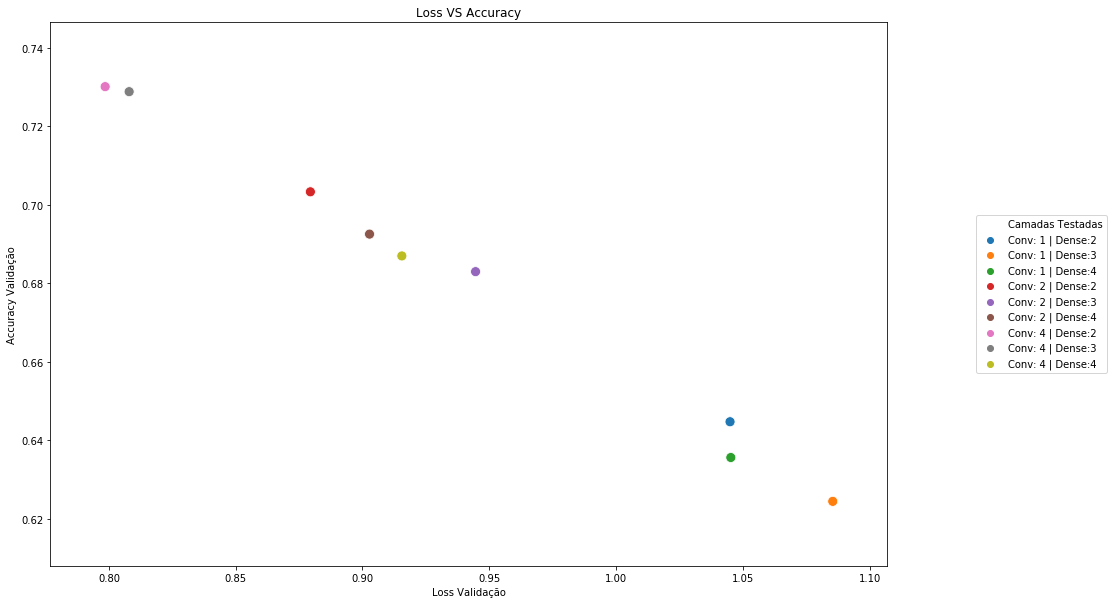

In [21]:
# Define tamanho da imagem
plt.figure(figsize=(15,10))
# Plot
sns.scatterplot(x="val_loss", y="val_accuracy", hue='Camadas Testadas', data=df, s=100,cmap='dark');
# Colocar legenda fora do grafico
plt.legend(loc='center left', bbox_to_anchor=(1.1, 0.5), ncol=1);
# Labels
plt.title('Loss VS Accuracy');
plt.xlabel('Loss Validação');
plt.ylabel('Accuracy Validação');

Para escolher o melhor modelo, precisamos avaliar aquele que apresenta **maior accuracy** e **menor loss**. Dado a busca de parâmetros, verifa-se que o modelo que melhor mais se adequa apresenta 4 camadas de convolução/*max pool* e 2 camadas *dense* (mais complexo que o primeiro modelo proposto). Todavia, seus resultados não se mostram tão satisfatórios para defini-lo como um modelo melhor. 

Logo, considerando a pergunta feita no início dessa Parte 6, o aumento de complexidade **não melhora** a acurácia sobre esse banco de dados (considerando os pressupostos estabelecidos neste notebook).

# Parte 7:  Conclusão
Através deste notebook foi possível entender um pouco mais sobre conceitos de:
- Redes convolucionais e suas características
- Redes totalmente conectadas
- Como aplicar uma otimização de hyper parâmetros

Infelizmente a busca de melhores hyper parâmetros não apresentou sucesso. Porém vale ressaltar que diversas características/parâmetros podem ser alterados para alcançar um melhor poder preditivo utilizando a arquitetura CNN + DNN.

Ao final é apresentado um modelo com uma acurácia em torno de **72%** de predição.

## Possíveis aperfeiçoamentos
- Avaliar se a qualidade da predição do modelo é balaceanda através das classes (as vezes acurácia pode ser uma métrica que engana)
- Testar diferentes hyper parâmetros


# Referências
Os materiais utilizados como base para este documento se encontram abaixo (na língua inglesa):
- [ref1](https://www.pyimagesearch.com/2018/12/31/keras-conv2d-and-convolutional-layers/)
- [ref2](https://www.tensorflow.org/tutorials/images/cnn)
- [ref3](https://keras.io/layers/convolutional/)
- [ref4](http://deeplearning.net/software/theano/tutorial/conv_arithmetic.html)
- [ref5](https://towardsdatascience.com/hyperparameter-optimization-with-keras-b82e6364ca53)
- [ref6](https://towardsdatascience.com/a-beginners-guide-to-convolutional-neural-networks-cnns-14649dbddce8)
- [ref7](https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53)
- [ref8](https://adeshpande3.github.io/adeshpande3.github.io/A-Beginner's-Guide-To-Understanding-Convolutional-Neural-Networks/)